In [1]:
import os
os.chdir('..')

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [4]:
path = Path().cwd() / 'data'

In [5]:
path_img = path / 'task1_train'
path_lbl = path / 'task1_masks'

In [6]:
get_mask = lambda x: path_lbl/f'{x.stem}_mask.png'

In [7]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/jupyter/RASM2019/data/task1_train/gen_28_Or 5593_0034.tif'),
 PosixPath('/home/jupyter/RASM2019/data/task1_train/gen_6_Or 5593_0024.tif'),
 PosixPath('/home/jupyter/RASM2019/data/task1_train/gen_13_Or 13006_0169.tif')]

In [8]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/jupyter/RASM2019/data/task1_masks/gen_12_Add MS 7474_0028_mask.png'),
 PosixPath('/home/jupyter/RASM2019/data/task1_masks/gen_12_Or 3366_0111_mask.png'),
 PosixPath('/home/jupyter/RASM2019/data/task1_masks/gen_31_Add MS 7474_0032_mask.png')]

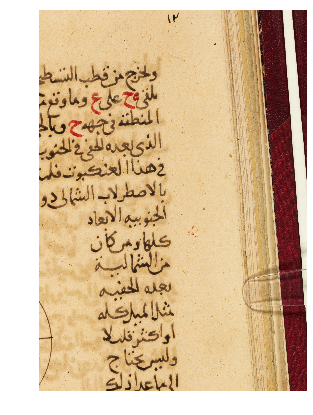

In [9]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(10,7))

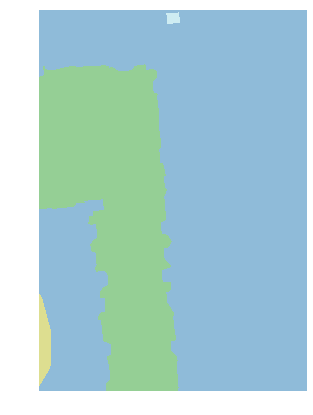

In [10]:
mask = open_mask(get_mask(img_f))
mask.show(figsize=(10,7))

In [11]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([8396, 5901]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [12]:
src_size // 12

array([699, 491])

In [13]:
class_labels = [
    'page',
    'paragraph',
    'marginalia',
    'caption',
    'graphic',
    'page-number',
    'other'
]

In [19]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 15068MB of GPU RAM free


In [14]:
bs = 12

In [15]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_rand_pct()
       .label_from_func(get_mask, classes=class_labels))

In [16]:
data = (src.transform(None, size=128, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

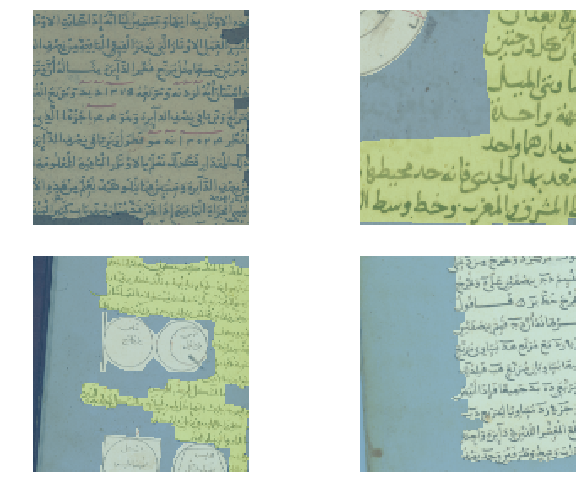

In [17]:
data.show_batch(2, figsize=(10,7))

In [18]:
wd=1e-2

In [19]:
learn = unet_learner(data, models.resnet34, wd=1e-2)
learn.model = torch.nn.DataParallel(learn.model, device_ids=[0, 1])

In [27]:
# learn = unet_learner(data, models.resnet34, metrics=accuracy, wd=wd)

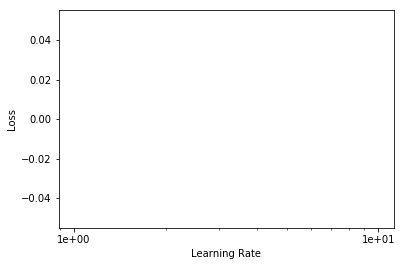

In [21]:
# lr_find(learn)
learn.recorder.plot()

In [29]:
lr=3e-4

In [30]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,time


RuntimeError: The size of tensor a (896) must match the size of tensor b (16384) at non-singleton dimension 1

In [31]:
import torch

In [32]:
torch.cuda.device_count()

2

In [33]:
torch.cuda.get_device_name(0)

'Tesla T4'